In [24]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, Activation, GRU, SpatialDropout1D

In [2]:
import os
print(os.getcwd())

C:\Users\w10165927\Code\Tweet\Tweet Code


In [3]:
file_path = r'C:\Users\w10165927\Code\Tweet\Dataset\Tweet-Arabic.xls'
data = pd.read_excel(file_path)

In [4]:
data.head(5)

,Unnamed: 0,Text,Tag,Unnamed: 3
0,0,@MazinAlEshaiker ويعتبر DDOS هجوم الكتروني يعط...,DDoS,0
1,1,@MazinAlEshaiker استاذ مازن الورد هذا توقف مؤق...,DDoS,1
2,2,RT @Saif_Bin_Safwan: يستخدم المتسللون البنغلاد...,DDoS,1
3,3,يستخدم المتسللون البنغلاديشيون هجمات DDoS (رفض...,DDoS,1
4,4,@yusefren @github هذا رابط يحتوى على كود fishi...,DDoS,1


In [5]:
data.rename(columns = {data.columns[3]: 'Class'}, inplace = True)

In [6]:
data.head(5)

,Unnamed: 0,Text,Tag,Class
0,0,@MazinAlEshaiker ويعتبر DDOS هجوم الكتروني يعط...,DDoS,0
1,1,@MazinAlEshaiker استاذ مازن الورد هذا توقف مؤق...,DDoS,1
2,2,RT @Saif_Bin_Safwan: يستخدم المتسللون البنغلاد...,DDoS,1
3,3,يستخدم المتسللون البنغلاديشيون هجمات DDoS (رفض...,DDoS,1
4,4,@yusefren @github هذا رابط يحتوى على كود fishi...,DDoS,1


In [7]:
print(data['Class'].value_counts())

0    1605
1     418
Name: Class, dtype: int64


In [8]:
arabic_stopwords = set(stopwords.words('arabic'))
stemmer = ISRIStemmer()

In [9]:
# Function to clean and preprocess Arabic text
def preprocess_text(text):
    # Remove special characters, links, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^ء-ي\s]', '', text)  # Keep only Arabic characters and whitespace

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in arabic_stopwords]
    
    return ' '.join(tokens)

In [10]:
data['Cleaned_Data'] = data['Text'].apply(preprocess_text)

In [11]:
data.head(5)

,Unnamed: 0,Text,Tag,Class,Cleaned_Data
0,0,@MazinAlEshaiker ويعتبر DDOS هجوم الكتروني يعط...,DDoS,0,عبر هجم كترو عطل خدم عمل
1,1,@MazinAlEshaiker استاذ مازن الورد هذا توقف مؤق...,DDoS,1,ساذ ازن ورد وقف ؤقت سبب
2,2,RT @Saif_Bin_Safwan: يستخدم المتسللون البنغلاد...,DDoS,1,خدم تسلل بنغلاديشي هجم رفض خدم وزع ضد جال جال ...
3,3,يستخدم المتسللون البنغلاديشيون هجمات DDoS (رفض...,DDoS,1,خدم تسلل بنغلاديشي هجم رفض خدم وزع ضد جال جال ...
4,4,@yusefren @github هذا رابط يحتوى على كود fishi...,DDoS,1,ربط حوى كود ويستخدمه هاكرز إختراق جهز حول الى ...


In [12]:
max_words = 5000
max_len = 100

X = data['Cleaned_Data'].tolist()
y = data['Class'].values

In [13]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen = max_len, padding = 'post')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.2, random_state = 42)

In [15]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Threat', 'Non-Threat'], output_dict=True)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Threat', 'Non-Threat']))
    return acc, report

In [16]:
ml_results = {}
dl_results = {}

In [17]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_acc, lr_report = evaluate_model(lr, X_test, y_test, "Logistic Regression")
ml_results['Logistic Regression'] = lr_report

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Threat       0.80      0.98      0.88       324
  Non-Threat       0.20      0.02      0.04        81

    accuracy                           0.79       405
   macro avg       0.50      0.50      0.46       405
weighted avg       0.68      0.79      0.71       405



In [ ]:
# Support Vector Machine (SVM)
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_acc, svm_report = evaluate_model(svm, X_test, y_test, "SVM")
ml_results['SVM'] = svm_report

In [18]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_acc, rf_report = evaluate_model(rf, X_test, y_test, "Random Forest")
ml_results['Random Forest'] = rf_report

Random Forest Classification Report:
              precision    recall  f1-score   support

      Threat       0.92      0.98      0.95       324
  Non-Threat       0.91      0.65      0.76        81

    accuracy                           0.92       405
   macro avg       0.92      0.82      0.86       405
weighted avg       0.92      0.92      0.91       405



In [19]:
from gensim.models import Word2Vec

sentences = data['Cleaned_Data'].apply(lambda x: x.split()).tolist()

word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)


word2vec_model.save("custom_arabic_tweet_word2vec.model")


In [20]:
embedding_dim = 300

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for word, index in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]

In [26]:
def train_dl_model(model, model_name, X_train, y_train, X_test, y_test):
    # Use `.keras` extension instead of `.h5`
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras', monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                        callbacks=[checkpoint, early_stop], verbose=1)
    
    # Load the best model based on validation loss
    model.load_weights(f'best_{model_name}.keras')
    
    # Evaluate model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Threat', 'Non-Threat'], output_dict=True)
    
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Threat', 'Non-Threat']))
    
    return acc, report, history

In [22]:
num_classes = len(np.unique(y))

model_RNN = Sequential([
    Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = embedding_dim,
                weights = [embedding_matrix],
                input_length = max_len,
                trainable = True),
    Bidirectional(SimpleRNN(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_RNN.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.005),
                 metrics = ['accuracy'])
model_RNN.build(input_shape = (None, max_len))
model_RNN.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │         942,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         109,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,120,894 (4.28 MB)

 Trainable params: 1,120,894 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
rnn_acc, rnn_report, rnn_history = train_dl_model(model_RNN, 'RNN', X_train, y_train, X_test, y_test)
dl_results['RNN'] = rnn_report

# history_RNN = model_RNN.fit(X_train, y_train, epochs = 50, batch_size = 32, 
#                             validation_data = (X_test, y_test))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.7999 - loss: 0.5123 - val_accuracy: 0.7809 - val_loss: 0.5276
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7998 - loss: 0.5121 - val_accuracy: 0.7809 - val_loss: 0.5263
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.7873 - loss: 0.5214 - val_accuracy: 0.7809 - val_loss: 0.5277
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.7801 - loss: 0.5317 - val_accuracy: 0.7809 - val_loss: 0.5277
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.7948 - loss: 0.5145 - val_accuracy: 0.7809 - val_loss: 0.5258
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.7946 - loss: 0.5116 - val_accuracy: 0.7809 - val_loss: 0.5258
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.7901 - loss: 0.5157 - val_accuracy: 0.7809 - val_loss: 0.5263
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.7971 - loss: 0.5043 - val_accuracy: 0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [63]:
import pickle

with open(r'C:\Users\w10165927\Code\Tweet\Result\rnn_arabic_history.pkl', 'wb') as f:
    pickle.dump(rnn_history.history, f)

In [64]:
with open(r'C:\Users\w10165927\Code\Tweet\Result\rnn_arabic_history.pkl', 'rb') as f:
    loaded_rnn_history = pickle.load(f)

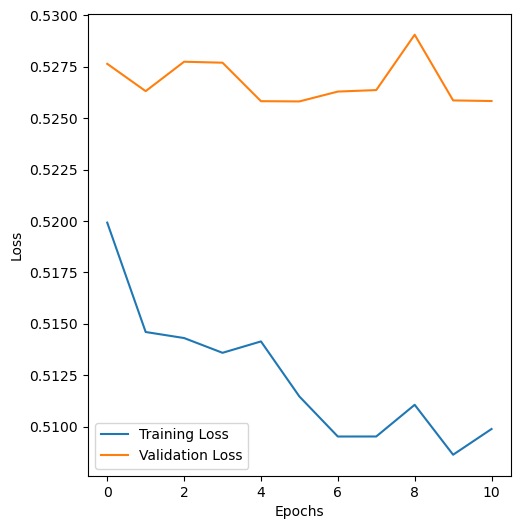

In [33]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_rnn_history['loss'], label = 'Training Loss')
plt.plot(loaded_rnn_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

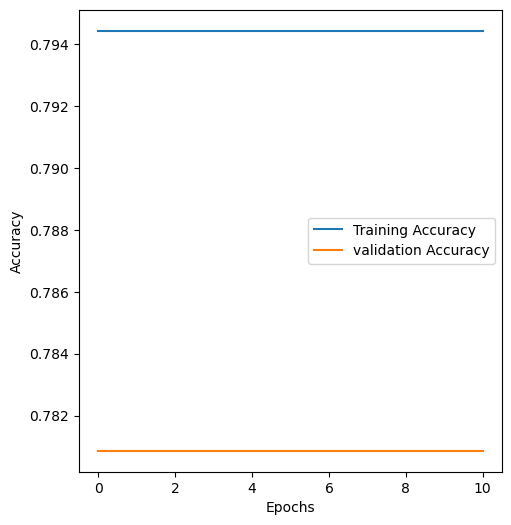

In [34]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_rnn_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_rnn_history['val_accuracy'], label =  'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# LSTM Code

In [47]:
num_classes = len(np.unique(y))
model_lstm = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) +1, output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(128, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])
model_lstm.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
model_lstm.build(input_shape= (None, max_len))
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 300)            │         942,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 100, 128)            │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 100, 128)            │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,240,830 (4.73 MB)

 Trainable params: 1,240,830 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
lstm_acc, lstm_report, lstm_history = train_dl_model(model_lstm, 'LSTM', X_train, y_train, X_test, y_test)
dl_results['LSTM'] = lstm_report

# history_lstm = model_lstm.fit(X_train, y_train,
#                              epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.7408 - loss: 8.7246 - val_accuracy: 0.7809 - val_loss: 5.9199
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.8052 - loss: 5.2118 - val_accuracy: 0.8951 - val_loss: 3.4998
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9142 - loss: 3.0789 - val_accuracy: 0.9012 - val_loss: 2.1781
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9357 - loss: 1.9176 - val_accuracy: 0.9105 - val_loss: 1.5095
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9545 - loss: 1.1981 - val_accuracy: 0.9167 - val_loss: 1.0049
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9613 - loss: 0.7834 - val_accuracy: 0.9074 - val_loss: 0.7508
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9609 - loss: 0.5535 - val_accuracy: 0.9228 - val_loss: 0.6438
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9678 - loss: 0.4206 - val_accuracy: 0

In [65]:
with open(r'C:\Users\w10165927\Code\Tweet\Result\lstm_history.pkl', 'wb') as f:
    pickle.dump(lstm_history.history, f)

In [66]:
with open(r'C:\Users\w10165927\Code\Tweet\Result\lstm_history.pkl', 'rb') as f:
    loaded_lstm_history = pickle.load(f)

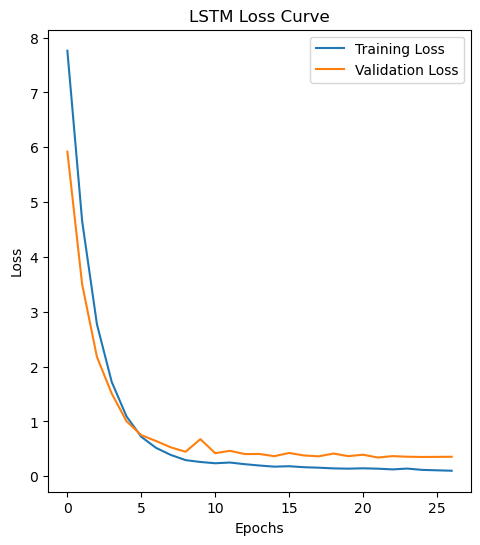

In [67]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_lstm_history['loss'], label = 'Training Loss')
plt.plot(loaded_lstm_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Loss Curve')
plt.legend()

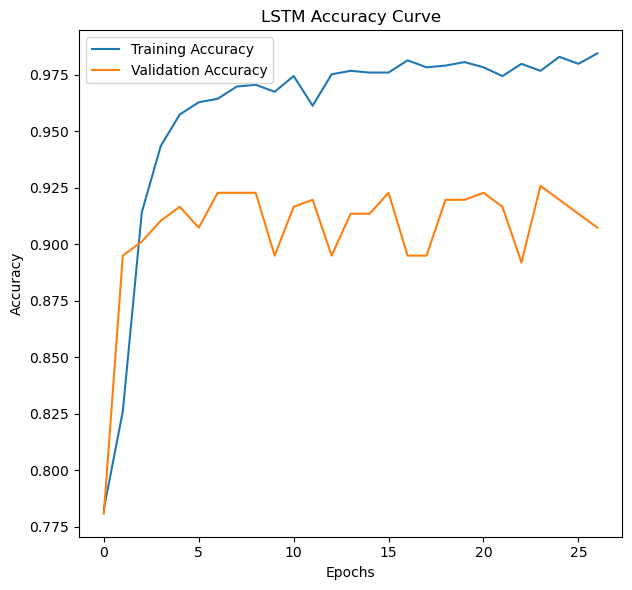

In [68]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_lstm_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_lstm_history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
num_classes = len(np.unique(y))

model_GRU = Sequential([
    Embedding(input_dim = len(tokenizer.word_index)+1,
             output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(GRU(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_GRU.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
model_GRU.build(input_shape = (None, max_len))
model_GRU.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 300)            │         942,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 100, 256)            │         330,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 64)                  │          12,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,337,342 (5.10 MB)

 Trainable params: 1,337,342 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
gru_acc, gru_report, gru_history = train_dl_model(model_GRU, 'GRU', X_train, y_train, X_test, y_test)
dl_results['LSTM'] = gru_report

# history_GRU = model_GRU.fit(X_train, y_train, validation_data = (X_test, y_test),
#                            epochs = 50,
#                            batch_size = 32)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 232ms/step - accuracy: 0.7040 - loss: 7.3712 - val_accuracy: 0.7809 - val_loss: 2.9667
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.8380 - loss: 2.3275 - val_accuracy: 0.9136 - val_loss: 1.1326
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9351 - loss: 0.8842 - val_accuracy: 0.9105 - val_loss: 0.6241
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9666 - loss: 0.4379 - val_accuracy: 0.9136 - val_loss: 0.4350
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9616 - loss: 0.3104 - val_accuracy: 0.8519 - val_loss: 0.4307
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9733 - loss: 0.2268 - val_accuracy: 0.9259 - val_loss: 0.3345
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.9756 - loss: 0.1654 - val_accuracy: 0.9228 - val_loss: 0.3183
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9814 - loss: 0.1371 - val_accuracy: 0

In [69]:
with open(r'C:\Users\w10165927\Code\Tweet\Result\gru_history.pkl', 'wb') as f:
    pickle.dump(gru_history.history, f)

In [70]:
with open(r'C:\Users\w10165927\Code\Tweet\Result\gru_history.pkl', 'rb') as f:
    loaded_GRU_history = pickle.load(f)

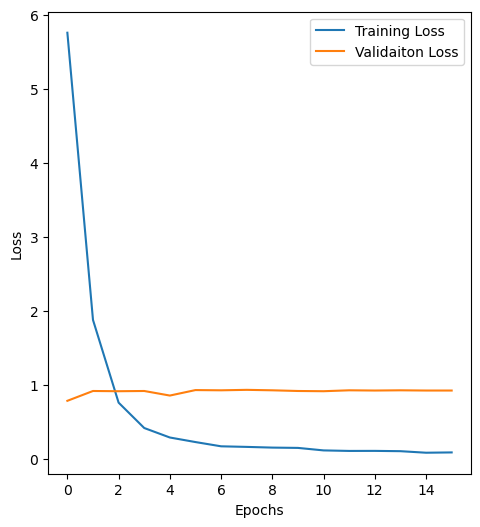

In [71]:
plt.figure(figsize =(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_GRU_history['loss'], label = 'Training Loss')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validaiton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

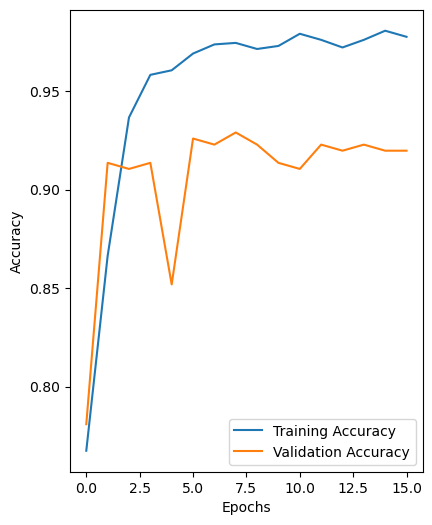

In [72]:
plt.figure(figsize = (10,6))
plt.subplot(1, 2, 2)
plt.plot(loaded_GRU_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [84]:
metrics = ['precision', 'recall', 'f1-score']
classes = ['Threat', 'Non-Threat']

comparison_table = {}

In [85]:
for model_name, report in {**ml_results, **dl_results}.items():
    for metric in metrics:
        for cls in classes:
            key = f"{metric}_{cls}"
            if key not in comparison_table:
                comparison_table[key] = []
            comparison_table[key].append(report[cls][metric])

comparison_df = pd.DataFrame(comparison_table, index=[*ml_results.keys(), *dl_results.keys()])

print("Comparison of ML and DL Models on Precision, Recall, and F1-score:")
print(comparison_df)

Comparison of ML and DL Models on Precision, Recall, and F1-score:
                     precision_Threat  precision_Non-Threat  recall_Threat  \
Logistic Regression          0.800000              0.200000       0.975309   
Random Forest                0.919308              0.913793       0.984568   
RNN                          0.800000              0.000000       1.000000   
LSTM                         0.956656              0.817073       0.953704   

                     recall_Non-Threat  f1-score_Threat  f1-score_Non-Threat  
Logistic Regression           0.024691         0.878999             0.043956  
Random Forest                 0.654321         0.950820             0.762590  
RNN                           0.000000         0.888889             0.000000  
LSTM                          0.827160         0.955178             0.822086  


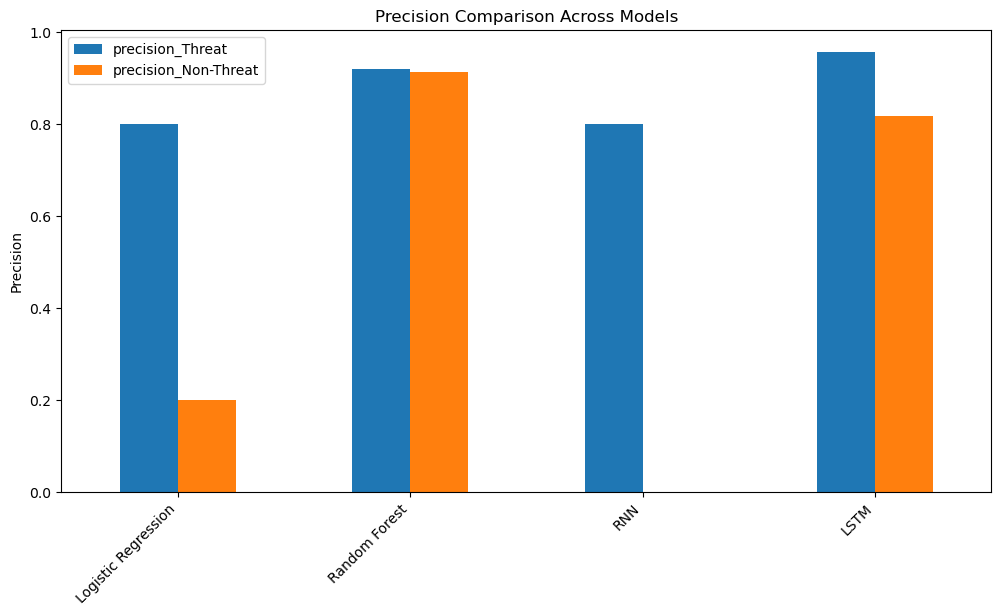

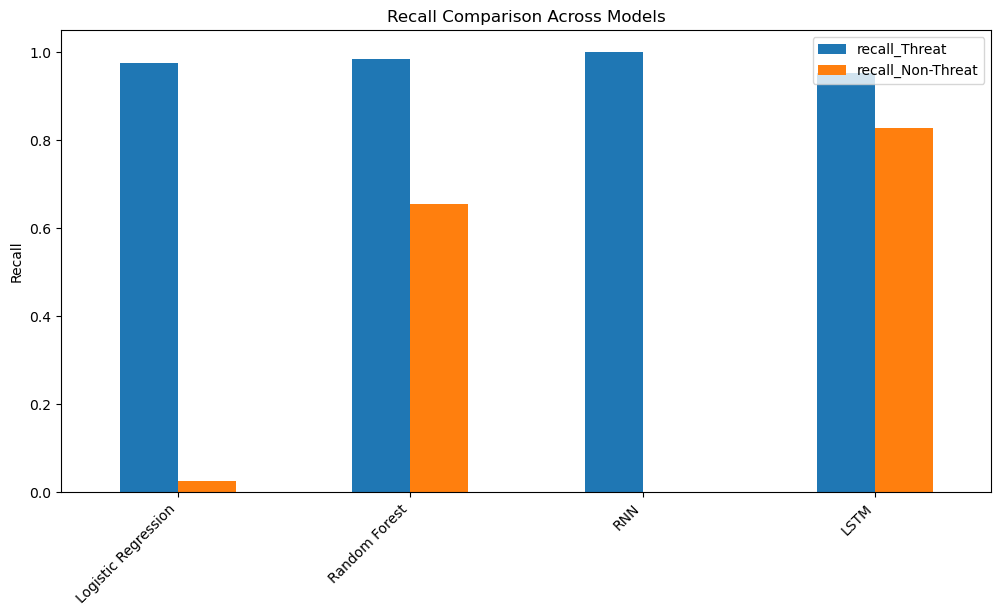

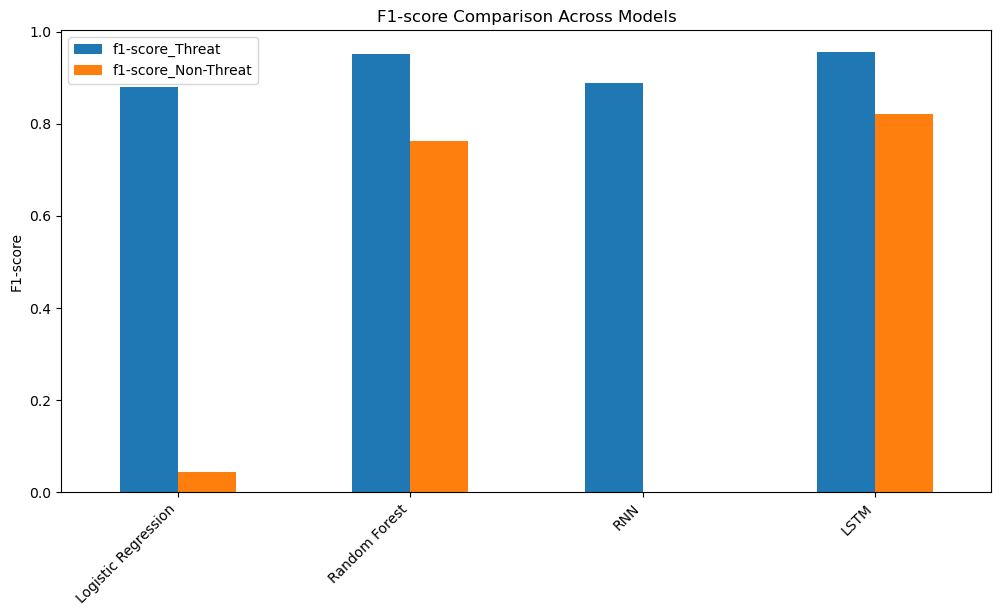

In [86]:
def plot_metric_comparison(metric):
    df = comparison_df[[f'{metric}_Threat', f'{metric}_Non-Threat']]
    df.plot(kind='bar', figsize=(12, 6))
    plt.title(f'{metric.capitalize()} Comparison Across Models')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_metric_comparison('precision')
plot_metric_comparison('recall')
plot_metric_comparison('f1-score')